# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

[2017-04-23 22:05:01,304] Making new env: CartPole-v0


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [6]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [7]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [8]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [12]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [13]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 26.0 Training loss: 1.0686 Explore P: 0.9974
Episode: 2 Total reward: 19.0 Training loss: 1.0405 Explore P: 0.9956
Episode: 3 Total reward: 11.0 Training loss: 1.0944 Explore P: 0.9945
Episode: 4 Total reward: 23.0 Training loss: 1.1110 Explore P: 0.9922
Episode: 5 Total reward: 12.0 Training loss: 1.1528 Explore P: 0.9910
Episode: 6 Total reward: 29.0 Training loss: 1.0690 Explore P: 0.9882
Episode: 7 Total reward: 34.0 Training loss: 1.1570 Explore P: 0.9849
Episode: 8 Total reward: 9.0 Training loss: 1.2039 Explore P: 0.9840
Episode: 9 Total reward: 21.0 Training loss: 1.0249 Explore P: 0.9820
Episode: 10 Total reward: 41.0 Training loss: 1.1783 Explore P: 0.9780
Episode: 11 Total reward: 14.0 Training loss: 1.2362 Explore P: 0.9766
Episode: 12 Total reward: 30.0 Training loss: 1.1643 Explore P: 0.9737
Episode: 13 Total reward: 20.0 Training loss: 1.3898 Explore P: 0.9718
Episode: 14 Total reward: 15.0 Training loss: 1.2170 Explore P: 0.9704
Episode: 15 Tota

Episode: 115 Total reward: 12.0 Training loss: 23.9490 Explore P: 0.7966
Episode: 116 Total reward: 10.0 Training loss: 29.0266 Explore P: 0.7958
Episode: 117 Total reward: 22.0 Training loss: 22.0448 Explore P: 0.7941
Episode: 118 Total reward: 12.0 Training loss: 27.0594 Explore P: 0.7931
Episode: 119 Total reward: 10.0 Training loss: 29.7172 Explore P: 0.7924
Episode: 120 Total reward: 13.0 Training loss: 22.0482 Explore P: 0.7913
Episode: 121 Total reward: 10.0 Training loss: 122.9055 Explore P: 0.7906
Episode: 122 Total reward: 20.0 Training loss: 169.1217 Explore P: 0.7890
Episode: 123 Total reward: 13.0 Training loss: 15.9531 Explore P: 0.7880
Episode: 124 Total reward: 18.0 Training loss: 116.5845 Explore P: 0.7866
Episode: 125 Total reward: 39.0 Training loss: 210.7692 Explore P: 0.7836
Episode: 126 Total reward: 39.0 Training loss: 274.7912 Explore P: 0.7806
Episode: 127 Total reward: 11.0 Training loss: 259.5380 Explore P: 0.7797
Episode: 128 Total reward: 12.0 Training loss

Episode: 228 Total reward: 14.0 Training loss: 197.0885 Explore P: 0.6685
Episode: 229 Total reward: 9.0 Training loss: 2.3660 Explore P: 0.6679
Episode: 230 Total reward: 28.0 Training loss: 4.4255 Explore P: 0.6660
Episode: 231 Total reward: 9.0 Training loss: 3.1812 Explore P: 0.6654
Episode: 232 Total reward: 19.0 Training loss: 150.5581 Explore P: 0.6642
Episode: 233 Total reward: 11.0 Training loss: 66.7480 Explore P: 0.6635
Episode: 234 Total reward: 19.0 Training loss: 162.8719 Explore P: 0.6622
Episode: 235 Total reward: 12.0 Training loss: 154.5101 Explore P: 0.6615
Episode: 236 Total reward: 15.0 Training loss: 30.7069 Explore P: 0.6605
Episode: 237 Total reward: 13.0 Training loss: 51.8314 Explore P: 0.6596
Episode: 238 Total reward: 11.0 Training loss: 27.8789 Explore P: 0.6589
Episode: 239 Total reward: 13.0 Training loss: 144.0284 Explore P: 0.6581
Episode: 240 Total reward: 26.0 Training loss: 31.8706 Explore P: 0.6564
Episode: 241 Total reward: 22.0 Training loss: 31.2

Episode: 341 Total reward: 14.0 Training loss: 108.4909 Explore P: 0.5650
Episode: 342 Total reward: 35.0 Training loss: 1.5268 Explore P: 0.5630
Episode: 343 Total reward: 13.0 Training loss: 58.7703 Explore P: 0.5623
Episode: 344 Total reward: 12.0 Training loss: 61.7685 Explore P: 0.5616
Episode: 345 Total reward: 10.0 Training loss: 0.8789 Explore P: 0.5611
Episode: 346 Total reward: 15.0 Training loss: 55.4810 Explore P: 0.5603
Episode: 347 Total reward: 22.0 Training loss: 56.3992 Explore P: 0.5591
Episode: 348 Total reward: 18.0 Training loss: 1.7700 Explore P: 0.5581
Episode: 349 Total reward: 14.0 Training loss: 74.8157 Explore P: 0.5573
Episode: 350 Total reward: 16.0 Training loss: 172.8413 Explore P: 0.5564
Episode: 351 Total reward: 9.0 Training loss: 65.2181 Explore P: 0.5559
Episode: 352 Total reward: 13.0 Training loss: 11.5124 Explore P: 0.5552
Episode: 353 Total reward: 11.0 Training loss: 35.7349 Explore P: 0.5546
Episode: 354 Total reward: 9.0 Training loss: 1.3673 

Episode: 455 Total reward: 19.0 Training loss: 1.6654 Explore P: 0.4166
Episode: 456 Total reward: 29.0 Training loss: 25.4729 Explore P: 0.4155
Episode: 457 Total reward: 20.0 Training loss: 2.0919 Explore P: 0.4146
Episode: 458 Total reward: 25.0 Training loss: 2.3135 Explore P: 0.4136
Episode: 459 Total reward: 16.0 Training loss: 1.0140 Explore P: 0.4130
Episode: 460 Total reward: 22.0 Training loss: 22.0076 Explore P: 0.4121
Episode: 461 Total reward: 39.0 Training loss: 12.2324 Explore P: 0.4105
Episode: 462 Total reward: 40.0 Training loss: 23.0689 Explore P: 0.4089
Episode: 463 Total reward: 29.0 Training loss: 1.7294 Explore P: 0.4078
Episode: 464 Total reward: 14.0 Training loss: 1.6621 Explore P: 0.4072
Episode: 465 Total reward: 39.0 Training loss: 74.1774 Explore P: 0.4057
Episode: 466 Total reward: 44.0 Training loss: 1.3453 Explore P: 0.4039
Episode: 467 Total reward: 24.0 Training loss: 18.8362 Explore P: 0.4030
Episode: 468 Total reward: 24.0 Training loss: 27.8258 Exp

Episode: 568 Total reward: 54.0 Training loss: 31.5034 Explore P: 0.2865
Episode: 569 Total reward: 43.0 Training loss: 29.7627 Explore P: 0.2853
Episode: 570 Total reward: 44.0 Training loss: 16.5313 Explore P: 0.2841
Episode: 571 Total reward: 32.0 Training loss: 29.9709 Explore P: 0.2832
Episode: 572 Total reward: 16.0 Training loss: 112.8475 Explore P: 0.2828
Episode: 573 Total reward: 35.0 Training loss: 22.5381 Explore P: 0.2818
Episode: 574 Total reward: 51.0 Training loss: 2.5492 Explore P: 0.2804
Episode: 575 Total reward: 57.0 Training loss: 0.8915 Explore P: 0.2789
Episode: 576 Total reward: 63.0 Training loss: 32.0108 Explore P: 0.2772
Episode: 577 Total reward: 57.0 Training loss: 30.1207 Explore P: 0.2757
Episode: 578 Total reward: 65.0 Training loss: 20.4330 Explore P: 0.2740
Episode: 579 Total reward: 40.0 Training loss: 1.1980 Explore P: 0.2729
Episode: 580 Total reward: 60.0 Training loss: 1.6532 Explore P: 0.2713
Episode: 581 Total reward: 72.0 Training loss: 16.4007

Episode: 681 Total reward: 131.0 Training loss: 2.3425 Explore P: 0.1348
Episode: 682 Total reward: 128.0 Training loss: 2.6956 Explore P: 0.1332
Episode: 683 Total reward: 199.0 Training loss: 1.0889 Explore P: 0.1307
Episode: 684 Total reward: 164.0 Training loss: 1.3769 Explore P: 0.1288
Episode: 685 Total reward: 199.0 Training loss: 2.4704 Explore P: 0.1264
Episode: 686 Total reward: 111.0 Training loss: 1.9913 Explore P: 0.1252
Episode: 687 Total reward: 177.0 Training loss: 28.3080 Explore P: 0.1231
Episode: 688 Total reward: 106.0 Training loss: 34.2392 Explore P: 0.1219
Episode: 689 Total reward: 113.0 Training loss: 1.7685 Explore P: 0.1207
Episode: 690 Total reward: 105.0 Training loss: 2.2598 Explore P: 0.1195
Episode: 691 Total reward: 124.0 Training loss: 1.6567 Explore P: 0.1182
Episode: 692 Total reward: 140.0 Training loss: 0.9535 Explore P: 0.1167
Episode: 693 Total reward: 172.0 Training loss: 1.8204 Explore P: 0.1149
Episode: 694 Total reward: 110.0 Training loss: 1

Episode: 794 Total reward: 119.0 Training loss: 0.5135 Explore P: 0.0471
Episode: 795 Total reward: 174.0 Training loss: 0.4112 Explore P: 0.0464
Episode: 796 Total reward: 193.0 Training loss: 0.2572 Explore P: 0.0457
Episode: 797 Total reward: 199.0 Training loss: 0.1965 Explore P: 0.0450
Episode: 798 Total reward: 199.0 Training loss: 0.1372 Explore P: 0.0443
Episode: 799 Total reward: 199.0 Training loss: 0.1044 Explore P: 0.0436
Episode: 800 Total reward: 199.0 Training loss: 0.1301 Explore P: 0.0430
Episode: 801 Total reward: 199.0 Training loss: 0.8526 Explore P: 0.0423
Episode: 802 Total reward: 199.0 Training loss: 0.2626 Explore P: 0.0417
Episode: 803 Total reward: 167.0 Training loss: 340.7808 Explore P: 0.0412
Episode: 804 Total reward: 107.0 Training loss: 0.3334 Explore P: 0.0408
Episode: 805 Total reward: 192.0 Training loss: 0.1105 Explore P: 0.0403
Episode: 806 Total reward: 199.0 Training loss: 0.3757 Explore P: 0.0397
Episode: 807 Total reward: 199.0 Training loss: 0

Episode: 907 Total reward: 199.0 Training loss: 0.2371 Explore P: 0.0145
Episode: 908 Total reward: 199.0 Training loss: 0.5044 Explore P: 0.0144
Episode: 909 Total reward: 199.0 Training loss: 0.3350 Explore P: 0.0143
Episode: 910 Total reward: 199.0 Training loss: 0.2417 Explore P: 0.0142
Episode: 911 Total reward: 199.0 Training loss: 229.7804 Explore P: 0.0141
Episode: 912 Total reward: 199.0 Training loss: 0.3465 Explore P: 0.0140
Episode: 913 Total reward: 199.0 Training loss: 0.2846 Explore P: 0.0139
Episode: 914 Total reward: 199.0 Training loss: 0.2786 Explore P: 0.0139
Episode: 915 Total reward: 199.0 Training loss: 0.1131 Explore P: 0.0138
Episode: 916 Total reward: 199.0 Training loss: 0.6292 Explore P: 0.0137
Episode: 917 Total reward: 199.0 Training loss: 390.3349 Explore P: 0.0136
Episode: 918 Total reward: 199.0 Training loss: 0.1807 Explore P: 0.0136
Episode: 919 Total reward: 199.0 Training loss: 0.2370 Explore P: 0.0135
Episode: 920 Total reward: 199.0 Training loss:

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

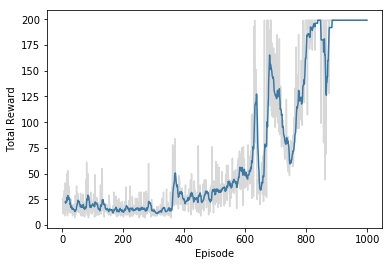

In [15]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [183]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.